#### 1. Proportion of revenue levels per tag
#### 2. Mean, standard deviation, median dollar value per tag
#### 3. Transaction frequency per tag

To do:
1. Number of unique merchants/consumers per tag - Andrew
2. Age distribution by tag (add visualization) - Andrew
3. Consumer income distribution by tag (add visualization) - Andrew
4. Take rate * Dollar_Value - Andrew
5. Unique SA2 per merchant - Patrick
6. Analyze buying power (transaction frequency and monetary value) of SA2, possibly ranking weights to merchants by SA2 - Patrick
 6.1 Add SA2 (Income, Age and Buying Power) Geospatial Visualization - Nadya
7. Finalize features to use -> find correlation between features

### Analysis by Tag

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import folium
from pyspark.sql import SparkSession, Window, functions as F
from pyspark.sql.functions import countDistinct, col, date_format
import numpy as np
import pyspark.sql.functions as func
from pyspark.sql.types import (
    StringType,
    LongType,
    DoubleType,
    StructField,
    StructType,
    FloatType
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Start Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/11 17:25:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# load BNPL dataset
consumer = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep="|")
details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")

In [4]:
# load all transactions datasets
paths=['../data/tables/transactions_20210228_20210827_snapshot',
       '../data/tables/transactions_20210828_20220227_snapshot']

first = 1
for path in paths:
    if first:
        transactions = spark.read.parquet(path)
        print(f'added {path.split("/")[3]}')
        first = 0
    else:
        append_transactions = spark.read.parquet(path)
        transactions = transactions.union(append_transactions)
        print(f'added {path.split("/")[3]}')

added transactions_20210228_20210827_snapshot


added transactions_20210828_20220227_snapshot


In [5]:
age = gpd.read_file("../data/abs/sa2_age.gml")
income = gpd.read_file("../data/abs/sa2_income.gml")

In [6]:
# load poa_to_sa2 dataset
poa_to_sa2 = spark.read.csv("../data/curated/poa_w_sa2.csv", header=True)

In [7]:
consumer.show(1, vertical=True)

-RECORD 0---------------------------
 name        | Yolanda Williams     
 address     | 413 Haney Gardens... 
 state       | WA                   
 postcode    | 6935                 
 gender      | Female               
 consumer_id | 1195503              
only showing top 1 row



In [8]:
details.show(1, vertical=True)

-RECORD 0--------------
 user_id     | 1       
 consumer_id | 1195503 
only showing top 1 row



In [9]:
transactions.agg({'order_datetime': 'max'}).show()
transactions.agg({'order_datetime': 'min'}).show()

+-------------------+
|max(order_datetime)|
+-------------------+
|         2022-02-27|
+-------------------+

+-------------------+
|min(order_datetime)|
+-------------------+
|         2021-02-28|
+-------------------+



In [10]:
merchants.show(1, vertical=True)

-RECORD 0----------------------------
 name         | Felis Limited        
 tags         | ((furniture, home... 
 merchant_abn | 10023283211          
only showing top 1 row



In [11]:
transactions.show(1, vertical=True)

-RECORD 0------------------------------
 user_id        | 18478                
 merchant_abn   | 62191208634          
 dollar_value   | 63.255848959735246   
 order_id       | 949a63c8-29f7-4ab... 
 order_datetime | 2021-08-20           
only showing top 1 row



In [12]:
# rename columns
merchants = merchants.withColumnRenamed('name', 'merchant_name')
consumer = consumer.withColumnRenamed('name', 'consumer_name')

---
### Merge transaction with consumer and merchant details

In [13]:
# Join consumers with their respective details
consumer_detail = consumer.join(details, on="consumer_id")

# Join consumers with their respective transactions
consumer_trx = consumer_detail.join(transactions, on="user_id")

# Join transactions with the respective merchants
df_trx = consumer_trx.join(merchants, on="merchant_abn")

In [14]:
df_trx.show(5, vertical=True)

-RECORD 0------------------------------
 merchant_abn   | 33064796871          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 373.0873675184212    
 order_id       | fe188788-b89f-4dd... 
 order_datetime | 2021-08-20           
 merchant_name  | Curabitur Massa C... 
 tags           | ((computer progra... 
-RECORD 1------------------------------
 merchant_abn   | 68435002949          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 232.5364986739752    
 order_id       | b4a89891-a113-45e... 


In [15]:
df_trx.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)



In [16]:
poa_to_sa2.show(5, vertical=True)

-RECORD 0---------------------------------
 poa_code_2016     | 800                  
 poa_name_2016     | 0800                 
 sa2_maincode_2016 | 701011002.0          
 sa2_name_2016     | Darwin City          
 geometry          | POLYGON ((130.834... 
-RECORD 1---------------------------------
 poa_code_2016     | 810                  
 poa_name_2016     | 0810                 
 sa2_maincode_2016 | 701021013.0          
 sa2_name_2016     | Brinkin - Nakara     
 geometry          | POLYGON ((130.863... 
-RECORD 2---------------------------------
 poa_code_2016     | 812                  
 poa_name_2016     | 0812                 
 sa2_maincode_2016 | 701021014.0          
 sa2_name_2016     | Buffalo Creek        
 geometry          | POLYGON ((130.901... 
-RECORD 3---------------------------------
 poa_code_2016     | 815                  
 poa_name_2016     | 0815                 
 sa2_maincode_2016 | 701021013.0          
 sa2_name_2016     | Brinkin - Nakara     
 geometry  

In [17]:
df_trx.show(5, vertical=True)

-RECORD 0------------------------------
 merchant_abn   | 33064796871          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 373.0873675184212    
 order_id       | fe188788-b89f-4dd... 
 order_datetime | 2021-08-20           
 merchant_name  | Curabitur Massa C... 
 tags           | ((computer progra... 
-RECORD 1------------------------------
 merchant_abn   | 68435002949          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 232.5364986739752    
 order_id       | b4a89891-a113-45e... 


In [18]:
# translate postcodes in transaction to sa2 codes
sa2_cols = ['poa_name_2016', 'sa2_maincode_2016', 'sa2_name_2016', 'geometry']
df_trx_sa2 = (df_trx \
                .join(poa_to_sa2[sa2_cols], 
                     on=[df_trx['postcode'] == poa_to_sa2['poa_name_2016']],
                     how='inner')
                .drop('poa_name_2016')
             )

In [19]:
df_trx.show(5, vertical=True)

-RECORD 0------------------------------
 merchant_abn   | 33064796871          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 373.0873675184212    
 order_id       | fe188788-b89f-4dd... 
 order_datetime | 2021-08-20           
 merchant_name  | Curabitur Massa C... 
 tags           | ((computer progra... 
-RECORD 1------------------------------
 merchant_abn   | 68435002949          
 user_id        | 7                    
 consumer_id    | 511685               
 consumer_name  | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 232.5364986739752    
 order_id       | b4a89891-a113-45e... 


In [20]:
# Explore product tags for purchase frequency
df_trx.groupby("tags").count().show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+-----+
|tags                                                                                                             |count|
+-----------------------------------------------------------------------------------------------------------------+-----+
|((lawn and garden suppLy outlets, including nurseries), (a), (take rate: 6.02))                                  |342  |
|[[watch, clock, and jewelry repair shops], [a], [take rate: 5.93]]                                               |5499 |
|[[florists supplies, nursery stock, and flowers], [a], [take rate: 5.58]]                                        |401  |
|([computer programming , data processing, and integrated systems design services], [a], [take rate: 6.79])       |1108 |
|([artist supply and craft shops], [a], [take rate: 6.04])                                                        |1046 |
|((tent and awning shops

In [21]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
@F.udf(StringType())
def normalize_tags(col):
    return col.replace("(", "[").replace(")", "]")[1:-1]

In [22]:
df_trx_sa2 = df_trx_sa2.withColumn("tags", normalize_tags(F.col("tags")))

In [23]:
df_trx.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)



In [24]:
df_trx_sa2 = df_trx_sa2.withColumn("categories", F.regexp_extract("tags", "(?<=\[)(.*?)(?=\])", 1))

In [25]:
df_trx_sa2 = df_trx_sa2.withColumn("revenue_level", F.regexp_extract("tags", "(?<=,\s\[)([a-e]+?)(?=\],)", 1))

In [26]:
df_trx_sa2 = df_trx_sa2.withColumn("take_rate", F.regexp_extract("tags", "(?<=\[take rate: )(.*?)(?=\])", 1))

In [27]:
df_trx_sa2 = df_trx_sa2.withColumn("take_rate", F.col("take_rate").astype(FloatType()))

In [28]:
@F.udf(StringType())
def clean_string(col):
    col = col.lower()
    return " ".join(col.split())

In [29]:
df_trx_sa2 = df_trx_sa2.withColumn("categories", clean_string(F.col("categories")))

In [30]:
category_take_rates = df_trx_sa2.select(["categories", "revenue_level", "take_rate"]).toPandas()

In [31]:
import pandas as pd
pd.set_option('display.max_rows', None)

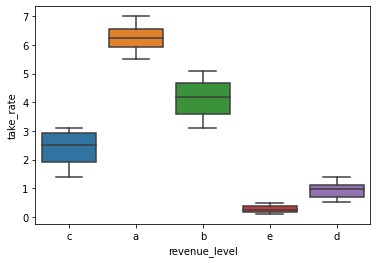

In [32]:
import seaborn as sns
sns.boxplot(category_take_rates["revenue_level"], category_take_rates["take_rate"])
plt.show()

Revenue levels can be categorized by its take rate

In [33]:
category_take_rates.groupby(["categories", "revenue_level"]).size().agg(
  {'count': lambda x: x, 'percent':lambda x: x / x.groupby(level=0).sum() * 100}
  ).unstack(level=0).reset_index()

,categories,revenue_level,count,percent
0,"antique shops - sales, repairs, and restoratio...",a,14165.0,16.546737
1,"antique shops - sales, repairs, and restoratio...",b,35881.0,41.914118
2,"antique shops - sales, repairs, and restoratio...",c,31970.0,37.345513
3,"antique shops - sales, repairs, and restoratio...",d,3080.0,3.597879
4,"antique shops - sales, repairs, and restoratio...",e,510.0,0.595753
5,art dealers and galleries,a,2819.0,27.558901
6,art dealers and galleries,b,5540.0,54.159742
7,art dealers and galleries,c,1608.0,15.720012
8,art dealers and galleries,d,27.0,0.263955
9,art dealers and galleries,e,235.0,2.297390


We can see which categories provide the better amount in revenue for our BNPL company

In [35]:
category_prices = df_trx_sa2.select(["categories", "dollar_value"]).toPandas()
category_prices = category_prices[category_prices["dollar_value"] >= 35]

In [36]:
category_prices.groupby("categories").agg(["mean", "std", "median", "count"])

dollar_value               \
                                                           mean          std   
categories                                                                     
antique shops - sales, repairs, and restoration...   412.777321  2089.413145   
art dealers and galleries                           2095.124768  2261.841612   
artist supply and craft shops                        403.965943   410.236982   
bicycle shops - sales and service                    369.754576   570.686431   
books, periodicals, and newspapers                   282.206695   235.657936   
cable, satellite, and other pay television and ...   101.408574    55.766953   
computer programming , data processing, and int...   214.516641   158.912953   
computers, computer peripheral equipment, and s...   238.913885   256.398853   
digital goods: books, movies, music                   89.982122    48.374061   
equipment, tool, furniture, and appliance rent ...  1552.474967  1734.891243   
florists supplies, nursery stock, and flowers        180.821069   189.657448   
furniture, home furnishings and equipment shops...   255.667868   477.136400   
gift, card, novelty, and souvenir shops               92.969999    49.756544   
health and beauty spas                               334.439518   283.048662   
hobby, toy and game shops                            326.283435   597.381199   
jewelry, watch, clock, and silverware shops         9314.724158  7610.737140   
lawn and garden supply outlets, including nurse...   339.376720   466.353024   
motor vehicle supplies and new parts                 381.132205   664.753409   
music shops - musical instruments, pianos, and ...   334.774261   414.773756   
opticians, optical goods, and eyeglasses             149.361499   157.229241   
shoe shops                                           232.942513   208.971962   
stationery, office supplies and printing and wr...   481.086309   372.755802   
telecom                                             1876.880437  1870.936950   
tent and awning shops                                204.926008   436.659852   
watch, clock, and jewelry repair shops               107.989546    73.350239   

                                                                         
                                                         median   count  
categories                                                               
antique shops - sales, repairs, and restoration...   147.006323   73844  
art dealers and galleries                           1566.347822   10097  
artist supply and craft shops                        267.499083  140402  
bicycle shops - sales and service                    137.101317   90635  
books, periodicals, and newspapers                   212.869792  167085  
cable, satellite, and other pay television and ...    87.040906  334057  
computer programming , data processing, and int...   177.191737  219187  
computers, computer peripheral equipment, and s...   120.188424  232392  
digital goods: books, movies, music                   77.517030  398162  
equipment, tool, furniture, and appliance rent ...   984.270815   14589  
florists supplies, nursery stock, and flowers         93.657625  253501  
furniture, home furnishings and equipment shops...   155.247814  207794  
gift, card, novelty, and souvenir shops               81.126657  526814  
health and beauty spas                               250.706441  104488  
hobby, toy and game shops                            113.360322   89063  
jewelry, watch, clock, and silverware shops         7590.698411    2353  
lawn and garden supply outlets, including nurse...   213.166067  153114  
motor vehicle supplies and new parts                 249.673044  138753  
music shops - musical instruments, pianos, and ...   132.751814  120938  
opticians, optical goods, and eyeglasses              87.609265  220480  
shoe shops                                           160.985658  175534  
stationery, office supplies and pr

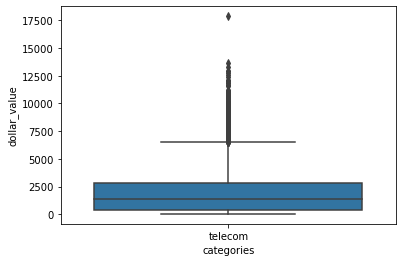

In [37]:
sns.boxplot(category_prices[category_prices["categories"] == "telecom"].loc[:,"categories"], \
    category_prices[category_prices["categories"] == "telecom"].loc[:,"dollar_value"])
plt.show()

1. Number of unique merchants/consumers per tag - Andrew
2. Age distribution by tag (add visualization) - Andrew
3. Consumer income distribution by tag (add visualization) - Andrew
4. Take rate * Dollar_Value - Andrew

1. Number of Unique Merchants and Consumer per Tag

In [38]:
df_trx_sa2.groupby("categories").agg(countDistinct("merchant_abn"), countDistinct("consumer_id"))

categories,count(merchant_abn),count(consumer_id)
"opticians, optica...",151,20066
"watch, clock, and...",170,20066
computer programm...,191,20066
digital goods: bo...,195,20066
"books, periodical...",164,20066
florists supplies...,180,20066
art dealers and g...,112,8014
antique shops - s...,120,19799
"gift, card, novel...",182,20066
"equipment, tool, ...",134,11721


Calculating Revenue (Take Rate / 100 * Dollar Value) and taking the top 10 highest revenues

In [39]:
@F.udf(FloatType())
def get_revenue(take_rate, dollar_value):
    return (take_rate / 100) * dollar_value

In [40]:
trx_over35 = df_trx_sa2.where(F.col("dollar_value") >= 35)
trx_over35 = trx_over35.withColumn("revenue", get_revenue(F.col("take_rate"), F.col("dollar_value")))

In [41]:
revenue_per_tag = trx_over35.groupby("categories").mean("revenue").sort("avg(revenue)", ascending=False)

In [42]:
top10_tags = revenue_per_tag.select("categories").head(10)
for i in range(len(top10_tags)):
    top10_tags[i] = top10_tags[i].__getitem__('categories')

top10_tags

['jewelry, watch, clock, and silverware shops',
 'art dealers and galleries',
 'telecom',
 'equipment, tool, furniture, and appliance rent al and leasing',
 'stationery, office supplies and printing and writing paper',
 'bicycle shops - sales and service',
 'artist supply and craft shops',
 'motor vehicle supplies and new parts',
 'antique shops - sales, repairs, and restoration services',
 'hobby, toy and game shops']

In [43]:
revenue_per_tag.limit(10)

categories,avg(revenue)
"jewelry, watch, c...",345.64322891414696
art dealers and g...,84.3527362486496
telecom,73.82940813190966
"equipment, tool, ...",57.033791029283314
"stationery, offic...",19.896942955281247
bicycle shops - s...,18.165461280633863
artist supply and...,18.000760546549643
motor vehicle sup...,17.578251643967917
antique shops - s...,17.462980811746036
"hobby, toy and ga...",15.503437210098797


2. Age distribution by tag

In [130]:
pd_age_tag = df_trx_sa2.select("sa2_maincode_2016", "categories").toPandas()

In [131]:
pd_age_tag["sa2_maincode_2016"] = pd_age_tag["sa2_maincode_2016"].astype("float64")

In [132]:
age_cols = ["sa2_main16", "persons_age_20_24", "persons_age_25_29" , "persons_age_30_34", "persons_age_35_39", "persons_age_40_44", \
    "persons_age_45_49", "persons_age_50_54", "persons_age_55_59", "persons_age_60_64", "persons_age_65_69", "persons_age_70_74", \
        "persons_age_75_79", "persons_age_80_84", "persons_age_85_plus"]

pd_age_tag = pd_age_tag.merge(age[age_cols], left_on="sa2_maincode_2016", right_on="sa2_main16", how="inner")

In [108]:
pd_age_tag_final = pd_age_tag.groupby(["categories", "sa2_main16"]).mean().groupby("categories").sum()

In [109]:
pd_age_tag_final["Total"] = pd_age_tag_final.sum(axis=1)

In [110]:
for column in age_cols[1:]:
    pd_age_tag_final[column] = pd_age_tag_final[column] / pd_age_tag_final["Total"] * 100

In [111]:
pd_age_tag_final.head()

,persons_age_20_24,persons_age_25_29,persons_age_30_34,persons_age_35_39,persons_age_40_44,persons_age_45_49,persons_age_50_54,persons_age_55_59,persons_age_60_64,persons_age_65_69,persons_age_70_74,persons_age_75_79,persons_age_80_84,persons_age_85_plus,Total
categories,,,,,,,,,,,,,,,
"antique shops - sales, repairs, and restoration services",7.706497,9.290586,10.072286,9.921263,9.236889,8.264352,8.737728,8.053485,7.346718,6.488773,5.594585,3.875369,2.663490,2.747977,12266987.0
art dealers and galleries,7.696171,9.275527,10.068801,9.929690,9.240456,8.264931,8.734369,8.053516,7.356990,6.499204,5.600708,3.875657,2.658204,2.745777,11847359.0
artist supply and craft shops,7.706497,9.290586,10.072286,9.921263,9.236889,8.264352,8.737728,8.053485,7.346718,6.488773,5.594585,3.875369,2.663490,2.747977,12266987.0
bicycle shops - sales and service,7.706497,9.290586,10.072286,9.921263,9.236889,8.264352,8.737728,8.053485,7.346718,6.488773,5.594585,3.875369,2.663490,2.747977,12266987.0
"books, periodicals, and newspapers",7.706497,9.290586,10.072286,9.921263,9.236889,8.264352,8.737728,8.053485,7.346718,6.488773,5.594585,3.875369,2.663490,2.747977,12266987.0


In [114]:
pd_age_tag_final = pd_age_tag_final.query("categories in @top10_tags")

In [115]:
pd_age_tag_final.head(10)
# Values displayed is the percentage of people in that age bracket

,persons_age_20_24,persons_age_25_29,persons_age_30_34,persons_age_35_39,persons_age_40_44,persons_age_45_49,persons_age_50_54,persons_age_55_59,persons_age_60_64,persons_age_65_69,persons_age_70_74,persons_age_75_79,persons_age_80_84,persons_age_85_plus,Total
categories,,,,,,,,,,,,,,,
"antique shops - sales, repairs, and restoration services",7.706497,9.290586,10.072286,9.921263,9.236889,8.264352,8.737728,8.053485,7.346718,6.488773,5.594585,3.875369,2.663490,2.747977,12266987.0
art dealers and galleries,7.696171,9.275527,10.068801,9.929690,9.240456,8.264931,8.734369,8.053516,7.356990,6.499204,5.600708,3.875657,2.658204,2.745777,11847359.0
artist supply and craft shops,7.706497,9.290586,10.072286,9.921263,9.236889,8.264352,8.737728,8.053485,7.346718,6.488773,5.594585,3.875369,2.663490,2.747977,12266987.0
bicycle shops - sales and service,7.706497,9.290586,10.072286,9.921263,9.236889,8.264352,8.737728,8.053485,7.346718,6.488773,5.594585,3.875369,2.663490,2.747977,12266987.0
"equipment, tool, furniture, and appliance rent al and leasing",7.695968,9.287843,10.076645,9.922888,9.236002,8.260214,8.732599,8.052141,7.353047,6.495641,5.597558,3.876581,2.663281,2.749593,12164019.0
"hobby, toy and game shops",7.706497,9.290586,10.072286,9.921263,9.236889,8.264352,8.737728,8.053485,7.346718,6.488773,5.594585,3.875369,2.663490,2.747977,12266987.0
"jewelry, watch, clock, and silverware shops",7.717269,9.330393,9.953976,9.777314,9.106428,8.153226,8.687920,8.067615,7.479914,6.657560,5.733659,3.941675,2.673313,2.719739,8327195.0
motor vehicle supplies and new parts,7.706497,9.290586,10.072286,9.921263,9.236889,8.264352,8.737728,8.053485,7.346718,6.488773,5.594585,3.875369,2.663490,2.747977,12266987.0
"stationery, office supplies and printing and writing paper",7.706497,9.290586,10.072286,9.921263,9.236889,8.264352,8.737728,8.053485,7.346718,6.488773,5.594585,3.875369,2.663490,2.747977,12266987.0


3. Consumer income distribution by tag

In [133]:
income_cols = ["sa2_code", "median_aud"]
pd_income_tag = pd_age_tag.merge(income[income_cols], left_on="sa2_maincode_2016", right_on="sa2_code")

In [134]:
pd_income_tag_final = pd_income_tag.groupby(["categories", "sa2_main16"]).mean().groupby("categories").agg({'median_aud': 'mean'})

In [135]:
pd_income_tag_final

,median_aud
categories,
"antique shops - sales, repairs, and restoration services",49423.353442
art dealers and galleries,49363.703437
artist supply and craft shops,49423.353442
bicycle shops - sales and service,49423.353442
"books, periodicals, and newspapers",49423.353442
"cable, satellite, and other pay television and radio services",49423.353442
"computer programming , data processing, and integrated systems design services",49423.353442
"computers, computer peripheral equipment, and software",49423.353442
"digital goods: books, movies, music",49423.353442


In [123]:
pd_income_tag_final = pd_income_tag_final.query("categories in @top10_tags")

In [124]:
pd_income_tag_final

,median_aud
categories,
"antique shops - sales, repairs, and restoration services",49423.353442
art dealers and galleries,49363.703437
artist supply and craft shops,49423.353442
bicycle shops - sales and service,49423.353442
"equipment, tool, furniture, and appliance rent al and leasing",49397.731669
"hobby, toy and game shops",49423.353442
"jewelry, watch, clock, and silverware shops",48599.783724
motor vehicle supplies and new parts,49423.353442
"stationery, office supplies and printing and writing paper",49423.353442


Median income for each tag is very similar

---
### 5. Unique SA2 per merchant


In [62]:
# translate postcodes in transaction to sa2 codes
sa2_cols = ['poa_name_2016', 'sa2_maincode_2016', 'sa2_name_2016', 'geometry']
df_trx_sa2 = (df_trx \
                .join(poa_to_sa2[sa2_cols], 
                     on=[df_trx['postcode'] == poa_to_sa2['poa_name_2016']],
                     how='inner')
                .drop('poa_name_2016')
             )

In [63]:
df_nunique_sa2 = (df_trx_sa2.groupby('merchant_abn')
                   .agg(countDistinct('sa2_maincode_2016')).toPandas())

In [64]:
df_nunique_sa2.head()

,merchant_abn,count(sa2_maincode_2016)
0,73256306726,940
1,83412691377,1222
2,73841664453,353
3,35344855546,487
4,15613631617,556


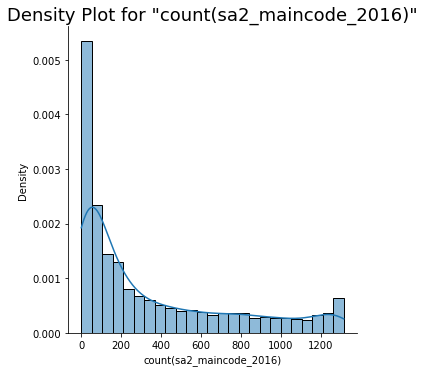

In [65]:
sns.displot(df_nunique_sa2["count(sa2_maincode_2016)"], 
            stat="density", kde=True, bins=25)
plt.title(f'Density Plot for "count(sa2_maincode_2016)"', fontsize=18)
plt.xlabel(f'count(sa2_maincode_2016)')
plt.show()

---
### 5. Unique consumer per merchant


In [66]:
df_nunique_con = (df_trx_sa2.groupby('merchant_abn')
                   .agg(countDistinct('consumer_id')).toPandas())

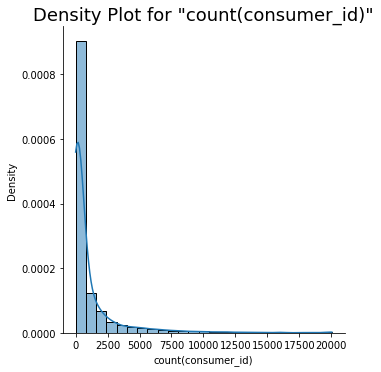

In [44]:
sns.displot(df_nunique_con["count(consumer_id)"], 
            stat="density", kde=True, bins=25)
plt.title(f'Density Plot for "count(consumer_id)"', fontsize=18)
plt.xlabel(f'count(consumer_id)')
plt.show()

---
### 6. Analyze buying power (transaction frequency and monetary value) of SA2, possibly ranking weights to merchants by SA2

In [70]:
(df_trx_sa2.groupby(['sa2_maincode_2016'])
               .agg(func.mean('dollar_value'))
               .sort(['sa2_maincode_2016']))

sa2_maincode_2016,avg(dollar_value)
101021007.0,155.17317588621663
101021011.0,154.8698299776638
101021012.0,158.92586491334723
101031013.0,151.7027122060417
101031014.0,161.69957907312084
101031015.0,152.55947893581808
101031016.0,161.13220956274444
101041020.0,164.78102251712104
101041022.0,165.8494109548918
101041024.0,164.20126127859018


In [77]:
sa2_trx = (df_trx_sa2.groupby(['sa2_maincode_2016', 'state'])
             .agg({'order_id':'count', 'dollar_value':'sum'})
             .sort(['sa2_maincode_2016', 'state']))
unique_cons = (df_trx_sa2.groupby(['sa2_maincode_2016', 'state'])
               .agg(countDistinct('consumer_id'))
               .sort(['sa2_maincode_2016', 'state']))
unique_merc = (df_trx_sa2.groupby(['sa2_maincode_2016', 'state'])
               .agg(countDistinct('merchant_abn'))
               .sort(['sa2_maincode_2016', 'state']))
avg_trx_val = (df_trx_sa2.groupby(['sa2_maincode_2016', 'state'])
               .agg(func.mean('dollar_value'))
               .sort(['sa2_maincode_2016', 'state']))

def join_agg(sdf1, sdf2):
    '''
        take two dataframes and join the two dataframes
    '''
    sdf1 = (sdf1.alias("a") \
               .join(sdf2, 
                     on=['sa2_maincode_2016', 'state'], 
                     how='inner')
           )
    return sdf1
df_buy_pow = join_agg(sa2_trx, unique_cons)
df_buy_pow = join_agg(df_buy_pow, unique_merc)
df_buy_pow = join_agg(df_buy_pow, avg_trx_val)
    
# renaming a few columns
field_name_change = {"sum(dollar_value)": "total_dollar_value",
                     "avg(dollar_value)": "avg_dollar_value",
                     "count(order_id)": "transaction_freq",
                     "count(consumer_id)": "n_unique_consumer",
                     "count(merchant_abn)": "n_unique_merchant"}
for old, new in field_name_change.items():
    df_buy_pow = df_buy_pow.withColumnRenamed(old, new)

cols = ['sa2_maincode_2016', 'state', 'n_unique_consumer', 'transaction_freq', 
        'total_dollar_value', 'avg_dollar_value', 'n_unique_merchant']
df_buy_pow = df_buy_pow[cols].sort(['sa2_maincode_2016'])

df_buy_pow = (df_buy_pow.
             withColumn('spending_per_customer', 
                        col("total_dollar_value") / col("n_unique_consumer")))

df_buy_pow = (df_buy_pow.
             withColumn('num_trx_per_customer', 
                        col("transaction_freq") / col("n_unique_consumer")))

df_buy_pow = (df_buy_pow.
             withColumn('sales_per_merchant', 
                        col("total_dollar_value") / col("n_unique_merchant")))

df_buy_pow = (df_buy_pow.
             withColumn('num_trx_per_merchant', 
                        col("transaction_freq") / col("n_unique_merchant")))

In [78]:
df_buy_pow.show(1, vertical=True)

-RECORD 0-----------------------------------
 sa2_maincode_2016     | 101021007.0        
 state                 | NSW                
 n_unique_consumer     | 9                  
 transaction_freq      | 2924               
 total_dollar_value    | 453726.3662912975  
 avg_dollar_value      | 155.17317588621663 
 n_unique_merchant     | 914                
 spending_per_customer | 50414.04069903305  
 num_trx_per_customer  | 324.8888888888889  
 sales_per_merchant    | 496.41834386356396 
 num_trx_per_merchant  | 3.199124726477024  
only showing top 1 row



Distribution for n_unique_consumer


Minimum n_unique_consumer by SA2: 1
Median n_unique_consumer by SA2: 10.0
Maximum n_unique_consumer by SA2: 152


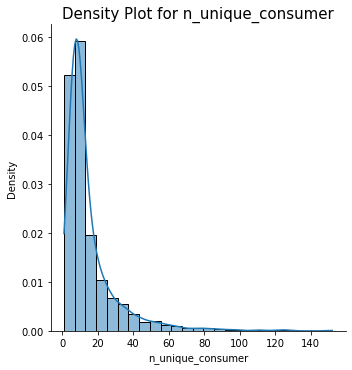

---------------------------------------------------------------------------
Distribution for transaction_freq


Minimum transaction_freq by SA2: 294
Median transaction_freq by SA2: 3187.0
Maximum transaction_freq by SA2: 49643


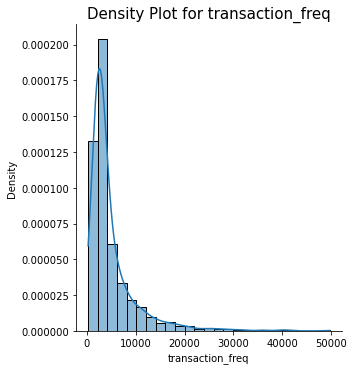

---------------------------------------------------------------------------
Distribution for total_dollar_value


Minimum total_dollar_value by SA2: 40952.08141779106
Median total_dollar_value by SA2: 493731.28025498806
Maximum total_dollar_value by SA2: 7975319.401259059


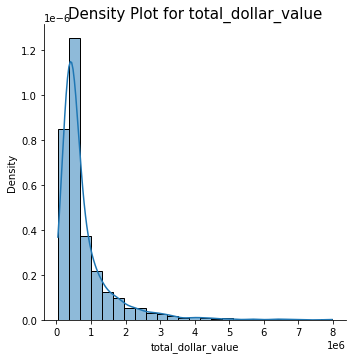

---------------------------------------------------------------------------
Distribution for n_unique_merchant


Minimum n_unique_merchant by SA2: 205
Median n_unique_merchant by SA2: 971.0
Maximum n_unique_merchant by SA2: 2613


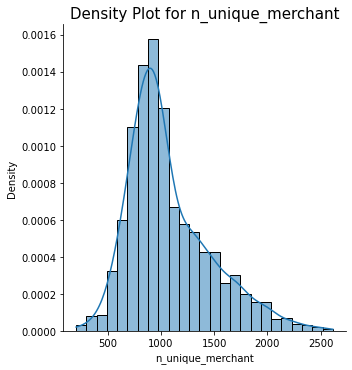

---------------------------------------------------------------------------
Distribution for spending_per_customer


Minimum spending_per_customer by SA2: 40952.08141779106
Median spending_per_customer by SA2: 51272.26223646662
Maximum spending_per_customer by SA2: 64688.66983317636


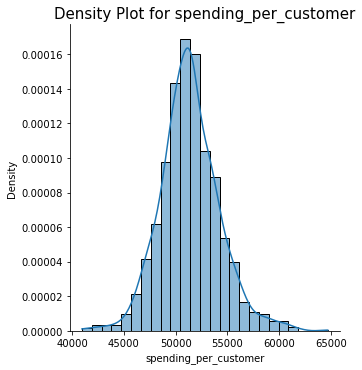

---------------------------------------------------------------------------
Distribution for num_trx_per_customer


Minimum num_trx_per_customer by SA2: 294.0
Median num_trx_per_customer by SA2: 324.6764705882353
Maximum num_trx_per_customer by SA2: 353.0


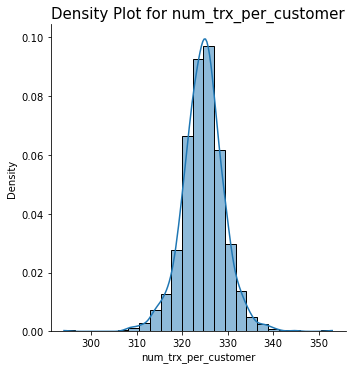

---------------------------------------------------------------------------
Distribution for sales_per_merchant


Minimum sales_per_merchant by SA2: 199.76625081849298
Median sales_per_merchant by SA2: 509.62802192201275
Maximum sales_per_merchant by SA2: 3052.169690493325


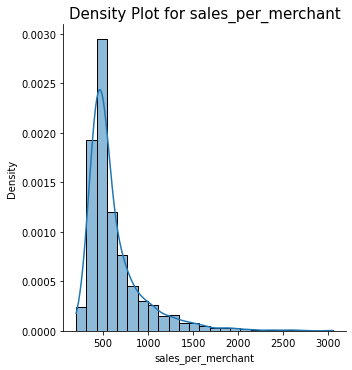

---------------------------------------------------------------------------
Distribution for num_trx_per_merchant


Minimum num_trx_per_merchant by SA2: 1.4266666666666667
Median num_trx_per_merchant by SA2: 3.2084942084942085
Maximum num_trx_per_merchant by SA2: 18.998469192499044


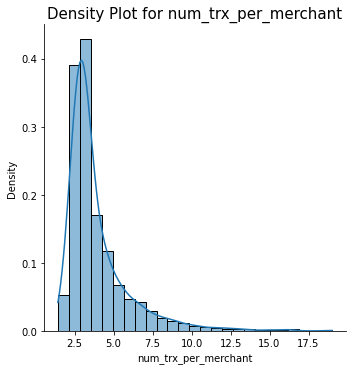

---------------------------------------------------------------------------
Distribution for avg_dollar_value


Minimum avg_dollar_value by SA2: 132.0982433302624
Median avg_dollar_value by SA2: 157.74687631079053
Maximum avg_dollar_value by SA2: 200.74063563437196


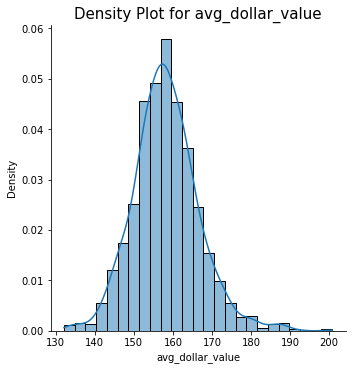

---------------------------------------------------------------------------


In [75]:
fields = ['n_unique_consumer', 'transaction_freq', 'total_dollar_value',
          'n_unique_merchant', 'spending_per_customer', 'num_trx_per_customer',
          'sales_per_merchant', 'num_trx_per_merchant', 'avg_dollar_value']

# get the distribution plot for the selected metrics
for field in fields:
    print(f'Distribution for {field}')
    df_field = df_buy_pow[[field]].toPandas()

    print(f'Minimum {field} by SA2: {df_field.min()[0]}')
    print(f'Median {field} by SA2: {df_field.median()[0]}')
    print(f'Maximum {field} by SA2: {df_field.max()[0]}')

    sns.displot(df_field[field], 
                stat="density", kde=True, bins=25)
    plt.title(f'Density Plot for {field}', fontsize=15)
    plt.xlabel(f'{field}')
    plt.show()
    
    print('---' * 25)

In [79]:
# Rank SA2 with the highest buying power (spending per customer)
(df_buy_pow[['sa2_maincode_2016', 'state', 'spending_per_customer']]
            .sort('spending_per_customer', ascending=False).limit(10))

sa2_maincode_2016,state,spending_per_customer
401051019.0,SA,64688.66983317636
407021158.0,SA,61815.98835492256
121031408.0,NSW,61810.87037921271
212021297.0,VIC,61025.98163991709
123021440.0,NSW,60753.80030982041
125011586.0,NSW,60736.50102319636
112011237.0,NSW,60705.686431131064
119041382.0,NSW,60618.38051112196
201011005.0,VIC,60342.76665212393
111031228.0,NSW,60170.21193200996


In [80]:
# Rank SA2 with the highest average transaction value (avg_dollar_value)
(df_buy_pow[['sa2_maincode_2016', 'state', 'avg_dollar_value']]
            .sort('avg_dollar_value', ascending=False).limit(10))

sa2_maincode_2016,state,avg_dollar_value
401051019.0,SA,200.74063563437196
407021158.0,SA,191.6774832710777
201011005.0,VIC,188.71858218021558
119041382.0,NSW,188.25584009665204
403021062.0,SA,188.03256531833262
212021297.0,VIC,187.7722511997449
407031168.0,SA,187.56982023267804
123021440.0,NSW,187.09925304388162
121031408.0,NSW,186.6592289277347
112011237.0,NSW,185.58124248647405


In [81]:
# Rank SA2 with the highest transaction frequency (num_trx_per_customer)
(df_buy_pow[['sa2_maincode_2016', 'state', 'num_trx_per_customer']]
            .sort('num_trx_per_customer', ascending=False).limit(10))

sa2_maincode_2016,state,num_trx_per_customer
309031239.0,QLD,353.0
801091106.0,ACT,344.6666666666667
507051187.0,WA,341.25
801051124.0,ACT,340.14285714285717
301031021.0,QLD,339.5
313021367.0,QLD,339.2
210051250.0,VIC,338.8
209021205.0,VIC,338.3333333333333
601031015.0,TAS,338.25
303011048.0,QLD,337.8888888888889


In [50]:
# check if the table above by taking one SA2 code
(df_trx_sa2.filter(F.col('sa2_maincode_2016') == 309031239.0)
 .groupby('consumer_id').agg({
                               'order_id':'count',
                               'dollar_value': 'sum' 
                            }))

consumer_id,sum(dollar_value),count(order_id)
41960,50475.727704169294,363
332215,64507.051132997134,343


In [51]:
age.head()

,gml_id,sa2_main16,state_code,state_name,gccsa_code16,gccsa_name16,sa4_code16,sa4_name16,sa3_code16,sa3_name16,...,persons_age_55_59,persons_age_5_9,persons_age_60_64,persons_age_65_69,persons_age_70_74,persons_age_75_79,persons_age_80_84,persons_age_85_plus,persons_total,geometry
0,abs_regional_population_age_sex_sa2_2019.10102...,101021007,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,...,318,381,404,333,288,194,89,75,4222,"MULTIPOLYGON (((149.58420 -35.44430, 149.58440..."
1,abs_regional_population_age_sex_sa2_2019.10102...,101021008,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,...,570,544,508,410,332,249,136,105,8372,"MULTIPOLYGON (((149.21900 -35.36740, 149.21800..."
2,abs_regional_population_age_sex_sa2_2019.10103...,101031015,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10103,Snowy Mountains,...,276,289,283,292,220,176,91,66,3382,"MULTIPOLYGON (((148.60440 -36.13520, 148.60450..."
3,abs_regional_population_age_sex_sa2_2019.10103...,101031016,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10103,Snowy Mountains,...,503,528,468,368,265,167,90,72,7215,"MULTIPOLYGON (((148.27030 -36.46410, 148.27060..."
4,abs_regional_population_age_sex_sa2_2019.10104...,101041017,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10104,South Coast,...,422,545,677,700,662,480,264,310,8025,"MULTIPOLYGON (((150.23540 -35.70390, 150.23530..."


In [52]:
# calculate population of male/female with age above 20
left_age = 25
right_age = 29
age['males_above_20'] = age['males_age_20_24']
age['females_above_20'] = age['females_age_20_24']
age['persons_above_20'] = age['persons_age_20_24']

while right_age < 89:
    if right_age == 89:
        right_age = 'plus'

    age['males_above_20'] += age[f'males_age_{left_age}_{right_age}']
    age['females_above_20'] += age[f'females_age_{left_age}_{right_age}']
    age['persons_above_20'] += age[f'persons_age_{left_age}_{right_age}']
    
    left_age += 5
    right_age += 5

In [53]:
pdf_buy_pow = df_buy_pow.toPandas()

In [54]:
# merge df_trx_sa2 with income, age, and population
income['sa2_code'] = income['sa2_code'].astype('float').astype('str')
income_col = ['sa2_code', 'median_aud', 'earners_persons', 
              'median_age_of_earners_years']
pdf_buy_pow = pdf_buy_pow.merge(income[income_col],
                                left_on='sa2_maincode_2016',
                                right_on='sa2_code', how='left')

age['sa2_main16'] = age['sa2_main16'].astype('float').astype('str')
age_col = ['sa2_main16', 'males_above_20', 
           'females_above_20', 'persons_above_20']
pdf_buy_pow = pdf_buy_pow.merge(age[age_col],
                                left_on='sa2_maincode_2016',
                                right_on='sa2_main16', how='left')

In [55]:
pdf_buy_pow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1314 entries, 0 to 1313
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sa2_maincode_2016            1314 non-null   object 
 1   n_unique_consumer            1314 non-null   int64  
 2   transaction_freq             1314 non-null   int64  
 3   total_dollar_value           1314 non-null   float64
 4   n_unique_merchant            1314 non-null   int64  
 5   spending_per_customer        1314 non-null   float64
 6   num_trx_per_customer         1314 non-null   float64
 7   sales_per_merchant           1314 non-null   float64
 8   num_trx_per_merchant         1314 non-null   float64
 9   sa2_code                     1307 non-null   object 
 10  median_aud                   1293 non-null   float64
 11  earners_persons              1293 non-null   float64
 12  median_age_of_earners_years  1293 non-null   float64
 13  sa2_main16        

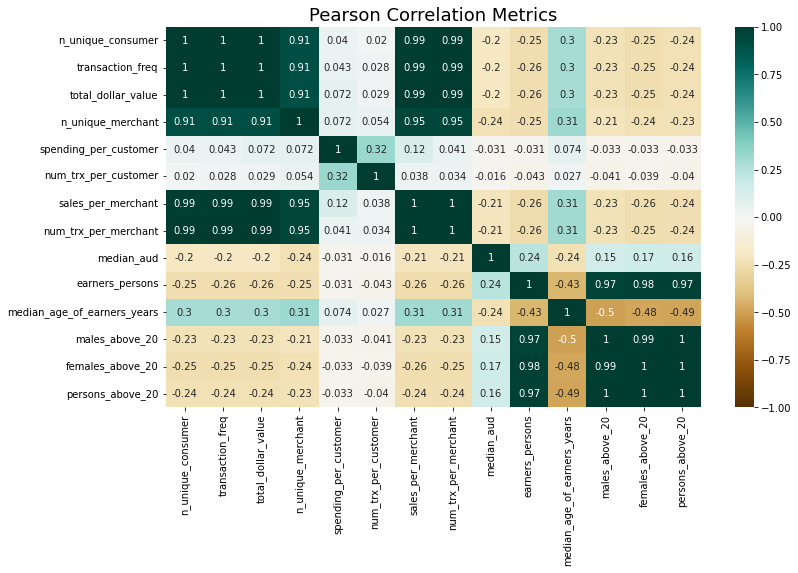

In [56]:
# check correlation between features of interest
fields = ['n_unique_consumer', 'transaction_freq', 'total_dollar_value',
          'n_unique_merchant', 'spending_per_customer', 'num_trx_per_customer',
          'sales_per_merchant', 'num_trx_per_merchant', 'median_aud', 
          'earners_persons', 'median_age_of_earners_years', 
          'males_above_20', 'females_above_20', 'persons_above_20']
plt.figure(figsize=(12,7))
sns.heatmap(pdf_buy_pow[fields].corr(method='pearson'), 
            vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.title('Pearson Correlation Metrics', fontsize=18)
plt.show()

### Revenue by SA2

In [44]:
df_trx_sa2 = df_trx_sa2.withColumn("revenue",
                                   get_revenue(F.col("take_rate"), 
                                               F.col("dollar_value")))

In [61]:
cols = ["sa2_maincode_2016", "state", "revenue"]

revenue_sa2 = (df_trx_sa2[cols].groupby(["sa2_maincode_2016", "state"])
               .agg(func.mean("revenue"), func.sum("revenue")))

revenue_sa2.sort("avg(revenue)", ascending=False).limit(10)

sa2_maincode_2016,state,avg(revenue),sum(revenue)
401051019.0,SA,9.202091606778696,23722.992162275477
108021156.0,NSW,8.715577345549075,19488.030944647733
407021158.0,SA,8.715165499435528,16863.845241407747
112011237.0,NSW,8.696545461862431,25602.629839723
214021377.0,VIC,8.40686425236705,19352.601508948952
125011586.0,NSW,8.39490548288538,27661.213566107326
407031168.0,SA,8.312590842563777,10423.988916574977
119041382.0,NSW,8.268645704833787,15975.023501738877
207031165.0,VIC,8.263169898192933,18616.921780628676
203021042.0,VIC,8.196989515947651,13303.713984383037


---
### SA2 (Income, Age and Buying Power) Geospatial Visualization